In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
%matplotlib inline

In [36]:
def get_X(df):
    # ones是m行一列的dataframe
    ones = pd.DataFrame({'ones': np.ones(len(df))})
    # 合并数据，根据列合并
    data = pd.concat([ones, df], axis=1)
    # 上面两行完成的操作，就是在原有的数据上添加一列全为0的数据
    
    # 返回ndarray,不是矩阵
    return data.iloc[:, :-1].values 

def get_y(df):
    # df.iloc[:, -1]是指df的最后一列
    return np.array(df.iloc[:, -1])

def normalize_feature(df):
    # 特征缩放
    return df.apply(lambda column: (column - column.mean()) / column.std())

def Hypothesis(X, theta):
    return X.dot(theta)

'''
X: R(m*n), m样本数, n特征数
y: R(m)
theta: R(n), 线性回归的参数,(假设函数的theta0,theta1)
'''
def lr_cost(theta, X, y):
    # m样本数
    m = X.shape[0]
    # 假设函数
    hypothesis = Hypothesis(X, theta)
    # 硬上公式
    cost = np.square(hypothesis - y).sum() / (2 * m)
    return cost

'''
批量梯度下降
'''

# 单次下降
def gradient(theta, X, y):
    m = X.shape[0]
    J = X.T.dot((Hypothesis(X, theta) - y)) / m
    #inner = X.T @ (X @ theta - y) / m
    return J

'''
批量梯度下降函数
拟合线性回归
iteration 迭代次数
'''
def batch_gradient_decent(theta, X, y, iteration, alpha = 0.01):
    cost_data = lr_cost(theta, X, y)
    # 拷贝一份theta数据，不与原来的混淆
    theta_copy = theta.copy()
    for _ in range(iteration):
        theta_copy = theta_copy - alpha * gradient(theta_copy, X, y)
        cost_data = np.append(cost_data, lr_cost(theta_copy, X, y))
    
    return theta_copy, cost_data

In [37]:
raw_data = pd.read_csv("ex1data2.txt",
                   names=['Square', 'Bedrooms', 'Price'])
print(raw_data.head())

   Square  Bedrooms   Price
0    2104         3  399900
1    1600         3  329900
2    2400         3  369000
3    1416         2  232000
4    3000         4  539900


## 标准化数据(特征缩放)

In [39]:
def normalize_feature(df):
    # 特征缩放
    return df.apply(lambda column: (column - column.mean()) / column.std())

In [40]:
data = normalize_feature(raw_data)
print(data.head())

     Square  Bedrooms     Price
0  0.130010 -0.223675  0.475747
1 -0.504190 -0.223675 -0.084074
2  0.502476 -0.223675  0.228626
3 -0.735723 -1.537767 -0.867025
4  1.257476  1.090417  1.595389


## multi-var batch gradient decent(多变量批量梯度下降)

In [41]:
X = get_X(data)
print(X.shape, type(X))

y = get_y(data)
print(y.shape, type(y))

(47, 3) <class 'numpy.ndarray'>
(47,) <class 'numpy.ndarray'>


In [42]:
# 学习率
alpha = 0.01
# theta变量 X.shape[1]: 特征数n
theta = np.zeros(X.shape[1])
# 迭代次数
iteration = 1000

In [43]:
final_theta, cost_data = batch_gradient_decent(theta, X, y, iteration, alpha)

C:\Users\TNanko\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


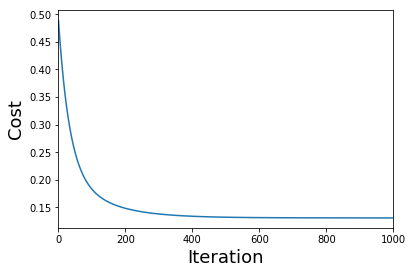

In [46]:
sns.tsplot(cost_data, np.arange(len(cost_data)))
plt.xlabel('Iteration', fontsize=18)
plt.ylabel('Cost', fontsize=18)
plt.show()

In [47]:
print(final_theta)

[-1.03049956e-16  8.78503652e-01 -4.69166570e-02]


## learning rate(学习率)

In [48]:
base = np.logspace(-1, -5, num=4)
new_alpha = np.sort(np.concatenate((base, base*3)))
print(new_alpha)

[1.00000000e-05 3.00000000e-05 2.15443469e-04 6.46330407e-04
 4.64158883e-03 1.39247665e-02 1.00000000e-01 3.00000000e-01]


In [49]:
fig, ax = plt.subplots(figsize=(16, 9))

for alpha in new_alpha:
    lr_theta, cost_data = batch_gradient_decent(theta, X, y, iteration, alpha)
    ax.plot(np.arange(iteration+1), cost_data, label=alpha)
    
ax.set_xlabel('Iteration', fontsize=18)
ax.set_ylabel('Cost', fontsize=18)
ax.set_title('Learning rate', fontsize=20)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## normal equation(正规方程)

In [50]:
def normalEqn(X, y):
    theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    return theta

In [51]:
# 和批量梯度下降的theta有点差距的
final_theta2 = normalEqn(X, y)
print(final_theta2)

[-1.04083409e-16  8.84765988e-01 -5.31788197e-02]


## Run the tensorflow graph over several optimizer
### 有点小问题

In [52]:
X_data = get_X(data)
print(X_data.shape, type(X_data))
y_data = get_y(data)
print(y_data.shape, type(y_data))

(47, 3) <class 'numpy.ndarray'>
(47,) <class 'numpy.ndarray'>


In [56]:
epoch = 2000
alpha = 0.01

In [57]:
def linear_regression(X_data, y_data, alpha, epoch, optimizer=tf.train.GradientDescentOptimizer):# 这个函数是旧金山的一个大神Lucas Shen写的
      # placeholder for graph input
    X = tf.placeholder(tf.float32, shape=X_data.shape)
    y = tf.placeholder(tf.float32, shape=y_data.shape)

    # construct the graph
    with tf.variable_scope('linear-regression'):
        W = tf.get_variable("weights",
                            (X_data.shape[1], 1),
                            initializer=tf.constant_initializer())  # n*1

        y_pred = tf.matmul(X, W)  # m*n @ n*1 -> m*1

        loss = 1 / (2 * len(X_data)) * tf.matmul((y_pred - y), (y_pred - y), transpose_a=True)  # (m*1).T @ m*1 = 1*1

    opt = optimizer(learning_rate=alpha)
    opt_operation = opt.minimize(loss)

    # run the session
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        loss_data = []

        for i in range(epoch):
            _, loss_val, W_val = sess.run([opt_operation, loss, W], feed_dict={X: X_data, y: y_data})
            loss_data.append(loss_val[0, 0])  # because every loss_val is 1*1 ndarray

            if len(loss_data) > 1 and np.abs(loss_data[-1] - loss_data[-2]) < 10 ** -9:  # early break when it's converged
                # print('Converged at epoch {}'.format(i))
                break

    # clear the graph
    tf.reset_default_graph()
    return {'loss': loss_data, 'parameters': W_val}  # just want to return in row vector format

In [64]:
optimizer_dict = {'GD': tf.train.GradientDescentOptimizer,
                  'Adagrad': tf.train.AdagradOptimizer,
                  'Adam': tf.train.AdamOptimizer,
                  'Ftrl': tf.train.FtrlOptimizer,
                  'RMS': tf.train.RMSPropOptimizer
                  }
results = []
for name in optimizer_dict:
    res = linear_regression(X_data, y_data, alpha, epoch, optimizer=optimizer_dict[name])
    res['name'] = name
    results.append(res)

C:\Users\TNanko\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in float_scalars
C:\Users\TNanko\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in less


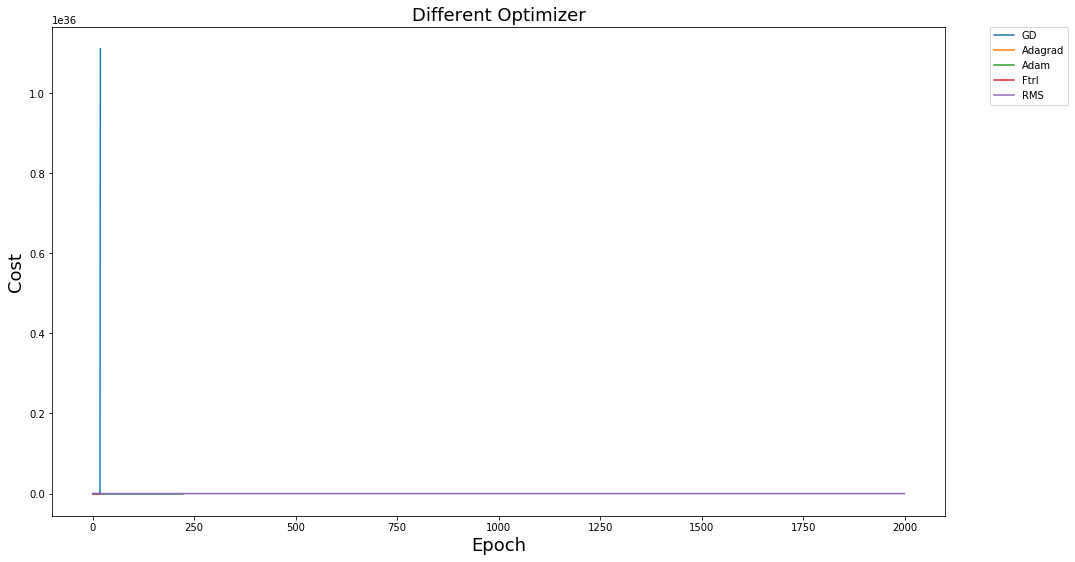

In [65]:
fig, ax = plt.subplots(figsize=(16, 9))
for res in results:
    loss_data = res['loss']
    ax.plot(np.arange(len(loss_data)), loss_data, label=res['name'])
    
ax.set_xlabel('Epoch', fontsize=18)
ax.set_ylabel('Cost', fontsize=18)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title('Different Optimizer', fontsize=18)
plt.show()